In [29]:
from classes.AndersonGraph import AndersonGraph
from plotting import plot_lattice_pdf
from animations import animate_lattice_pdf

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import networkx as nx
import numpy as np

n = 30
lattice = nx.grid_graph(dim=(n, n), periodic=True)
psi_0 = np.zeros(n**2)
psi_0[n**2//2] = 1

In [31]:
anderson_lattice = AndersonGraph(graph=lattice, psi_0=psi_0, eps_range=[-1, 1], t_hop=1)

MovieWriter ffmpeg unavailable; using Pillow instead.


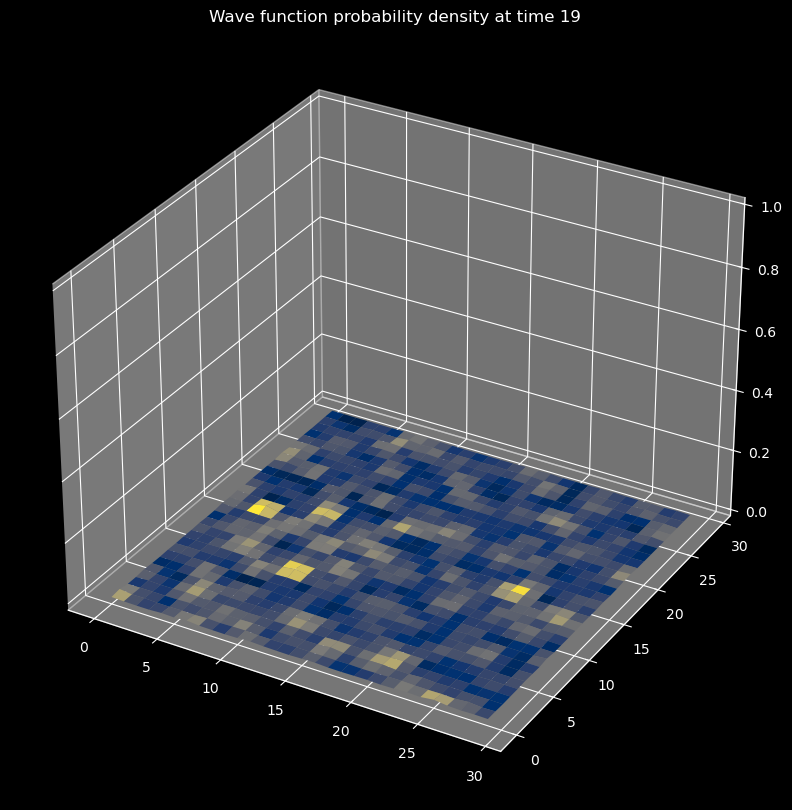

In [32]:
animate_lattice_pdf(anderson_lattice, 20, 0)

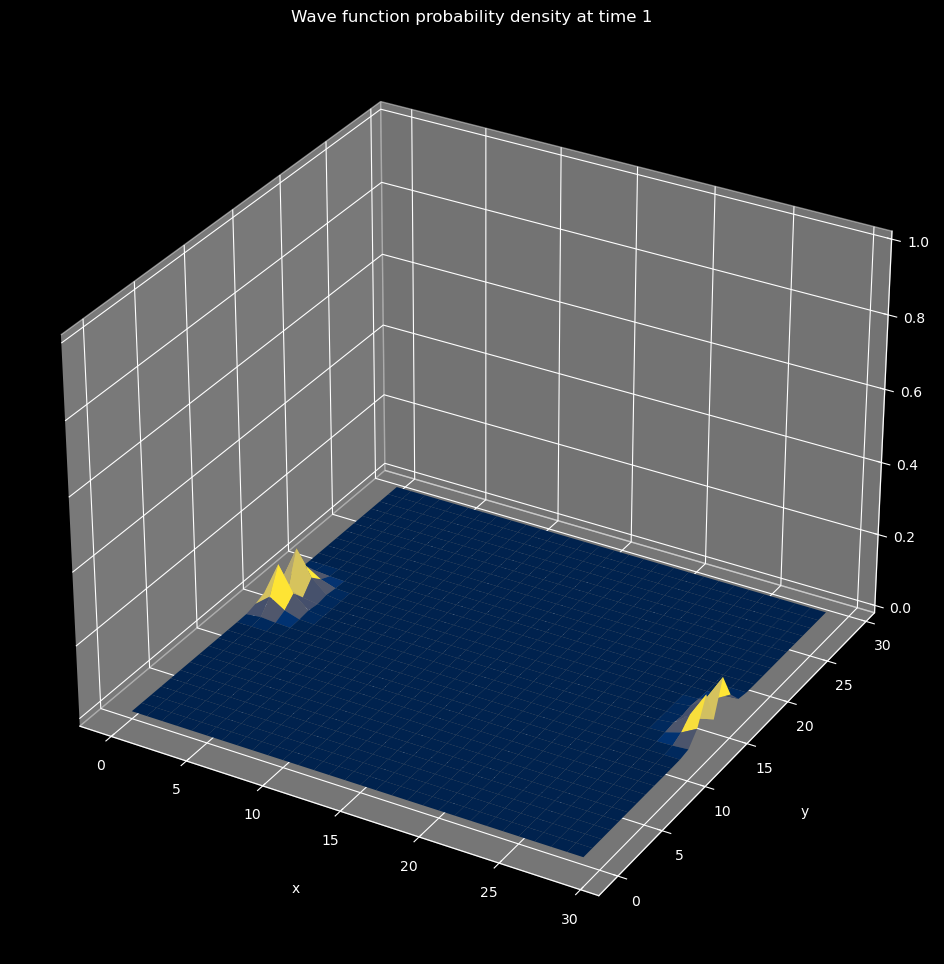

In [28]:
plot_lattice_pdf(anderson_lattice=anderson_lattice, time=1)

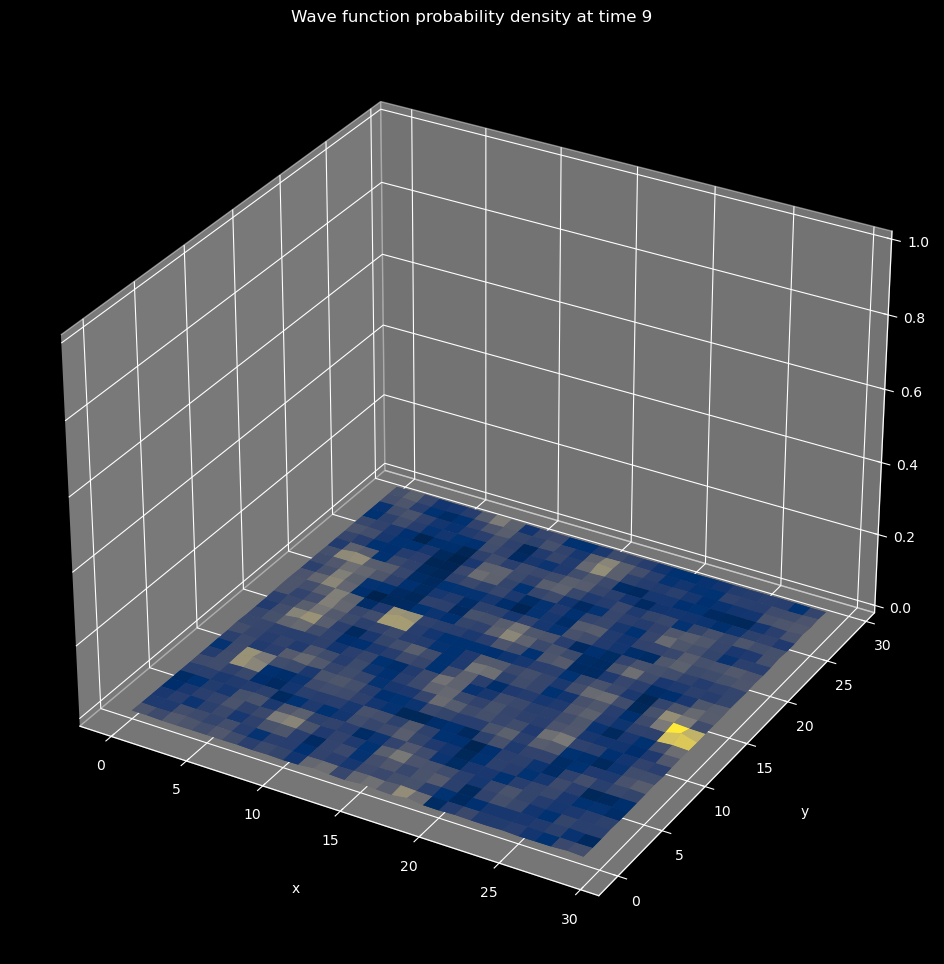

In [26]:
plot_lattice_pdf(anderson_lattice=anderson_lattice, time=9)

Old

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import expm

In [8]:
class AndersonChain:
    '''
    Construct and simulate a 1D Anderson lattice with periodic boundary conditions.
    We represent all wave functions and operators in the lattice site basis. 

    Attributes
        chain (1D ndarray): 
        psi0 (1D ndarray): 
        eps_range (array-like):
        t_hop (float):
        story_history (boolean):
    '''
    def __init__(self, num_sites, psi0, eps_range, t_hop, store_history=True):
        self.chain = np.zeros((num_sites, 1))
        self.psi0 = psi0
        self.eps_range = eps_range
        self.t_hop = t_hop # hopping param

        if store_history:
            self.history = []

    def _hamiltonian(self):
        '''
        Construct the hamiltonian for the Anderson tight-binding model, a matrix representation in the occupancy site basis. 
        '''
        binding = np.diagflat(np.random.uniform(*self.eps_range, size=(len(self.chain, ))))
        
        hopping = self.t_hop * (np.roll(np.identity(len(self.chain)), 1, axis=0) + np.roll(np.identity(len(self.chain)), -1, axis=0))
        
        return binding + hopping
    
    
    def _time_evolution(self, time):
        '''
        Calculate the unitary time evolution operator for the given hamiltonian.

        Args
            time (float): time when time evolution operator is calculated

        Returns
            U(t) (ndarray of size num_sites x num_sites) 
        '''

        return expm(-1j * self._hamiltonian() * time)
    

    def solveatt(self, time):
       
       return self._time_evolution(time) @ self.psi0
    

    def solve(self, t, nt): #t_steps):
        '''
        Calculate psi(t). 

        Args
            t (array-like): time range of form (t_initial, t_final)
            nt (int): number of time steps
        '''        

        times = np.linspace(*t, nt)
        
        history = []

        for time in times:
            psi_t = self._time_evolution(time) @ self.psi0
            history.append(psi_t) 
        
        return history

In [9]:
class AndersonLattice:
    '''
    Construct and simulate a 2D Anderson lattice with periodic boundary conditions.
    We represent all wave functions and operators in the lattice site basis. 

    Attributes
        chain (2D ndarray NxN): 
        psi0 (1D ndarray N^2): 
        eps_range (array-like):
        t_hop (float):
        store_history (boolean):
    '''
    def __init__(self, num_sites, psi_0, eps_range, t_hop, store_history=True):
        self.chain = np.zeros((num_sites, num_sites))
        self.num_sites = num_sites
        self.psi_0 = psi_0
        self.eps_range = eps_range
        self.t_hop = t_hop # hopping param
        self.binding = np.diagflat(np.random.uniform(*self.eps_range, size=(self.num_sites**2)))

        if store_history:
            self.history = []

    def _hamiltonian(self):
        '''
        Construct the hamiltonian for the Anderson tight-binding model, a matrix representation in the occupancy site basis. 
        '''
        G = nx.grid_graph(dim = (self.num_sites, self.num_sites), periodic=True)
        A = nx.to_numpy_array(G)
        hopping = -1*self.t_hop * A

        return self.binding + hopping
    
    
    def _time_evolution(self, time):
        '''
        Calculate the unitary time evolution operator for the given hamiltonian.

        Args
            time (float): time when time evolution operator is calculated

        Returns
            U(t) (ndarray of size num_sites x num_sites) 
        '''

        return expm(-1j * self._hamiltonian() * time)
    
    def solveatt(self, t):
        return self._time_evolution(t) @ self.psi_0
    
    
    def solve(self, t, nt): #t_steps):
        '''
        Calculate psi(t). 

        Args
            t (array-like): time range of form (t_initial, t_final)
            nt (int): number of time steps
        '''        

        times = np.linspace(0, t, nt)
        
        history = []

        for time in times:
            psi_t = self._time_evolution(time) @ self.psi_0
            history.append(psi_t) 
        
        return history
    
    def plotdensity(self, t, axisstabilized = False):
        '''
        Plot the probability density, aka |psi(t)|^2

        Args:
            t (float): time to plot it
        '''

        psi_t = self._time_evolution(t) @ self.psi_0
        density = np.real(np.multiply(psi_t.conj(), psi_t))
        dens2d = np.reshape(density, (self.num_sites, self.num_sites))

        fig = plt.figure(figsize = (12,12))
        plt.style.use('dark_background')
        ax = plt.axes(projection='3d')
        x = np.arange(0, self.num_sites, 1)
        y = np.arange(0, self.num_sites, 1)
        X, Y = np.meshgrid(x, y)

        surf = ax.plot_surface(X, Y, dens2d, cmap = plt.cm.cividis)
        
        # Set axes label
        ax.set_xlabel('x', labelpad=20)
        ax.set_ylabel('y', labelpad=20)
        ax.set_zlabel('P', labelpad=20)
        if axisstabilized==True:
            maxy = max(dens2d.flatten())
            ax.set_zlim((0, max(maxy, 0.2)))
        ax.set_title("Wave function probability density at time " + str(t))

        #plt.colorbar(surf)

        plt.show()
    

In [10]:
class RandomGraph:
    '''
    Construct and simulate a random graph.
    We represent all wave functions and operators in the lattice site basis. 

    Attributes
        chain (2D ndarray NxN): 
        psi0 (1D ndarray N^2): 
        eps_range (array-like):
        t_hop (float):
        store_history (boolean):
    '''
    def __init__(self, p, num_sites, psi_0, eps_range, t_hop, store_history=True):
        self.chain = np.zeros((num_sites, num_sites))
        self.num_sites = num_sites
        self.psi_0 = psi_0
        self.eps_range = eps_range
        self.t_hop = t_hop # hopping param
        self.p = p
        self.G = nx.erdos_renyi_graph(self.num_sites, self.p)
        self.binding = np.diagflat(np.random.uniform(*self.eps_range, size=self.num_sites))
        self.pos = nx.spring_layout(self.G)

        if store_history:
            self.history = []


    def _hamiltonian(self):
        '''
        Construct the hamiltonian for the Anderson tight-binding model, a matrix representation in the occupancy site basis. 
        but with a random graph instead with probability p
        '''
        A = nx.to_numpy_array(self.G)
        hopping = -1*self.t_hop * A

        return self.binding + hopping
    
    def _time_evolution(self, time):
        '''
        Calculate the unitary time evolution operator for the given hamiltonian.

        Args
            time (float): time when time evolution operator is calculated

        Returns
            U(t) (ndarray of size num_sites x num_sites) 
        '''

        return expm(-1j * self._hamiltonian() * time)
    
    def solveatt(self, time):
        return self._time_evolution(time) @ self.psi_0
    
    def solve(self, t, nt): #t_steps):
        '''
        Calculate psi(t). 

        Args
            t (array-like): time range of form (t_initial, t_final)
            nt (int): number of time steps
        '''        

        times = np.linspace(0, t, nt)
        
        history = []

        for time in times:
            psi_t = self._time_evolution(time) @ self.psi_0
            history.append(psi_t) 
        
        return history
    
    def plotgraph(self):
        nx.draw(self.G)

    def plotdensity(self, t, axisstabilized = False):
        '''
        Plot the probability density, aka |psi(t)|^2

        Args:
            t (float): time to plot it
        '''
        
        fig = plt.figure(figsize = (12,10))
        psi_t = self._time_evolution(t) @ self.psi_0
        density = np.real(np.multiply(psi_t.conj(), psi_t))
        
        plt.title("Wave function probability density at time " + str(t) + "\n p = " + str(self.p)) 
      
        nx.draw(self.G, self.pos, node_color = density, cmap = plt.cm.cividis)
        
        plt.show()

In [31]:
class AndersonGraph:
    '''
    Construct a graph to time-evolve the Anderson hamiltonian on. 
    We represent all operators and state vectors in the lattice site basis. 

    Attributes
        graph (): underlying graph
        psi_0 (1D nd array):
        eps_range (array-like):
        t_hop (float):
        num_sites (int):
        binding (2D nd array):
        pos ():
    '''

    def __init__(self, graph, psi_0, eps_range, t_hop):
        self.graph = graph
        self.psi_0 = psi_0
        self.eps_range = eps_range
        self.t_hop = t_hop

        self.num_sites = self.graph.number_of_nodes()
        self.binding = np.diagflat(np.random.uniform(*self.eps_range, size=self.num_sites))
        self.pos = nx.spring_layout(self.graph)


    def _hamiltonian(self):
        '''
        Construct the hamiltonian for the Anderson tight-binding model, a matrix representation in the occupancy site basis. 
        but with a random graph instead with probability p
        '''
        adjacency = nx.to_numpy_array(self.graph)
        hopping = -self.t_hop * adjacency

        return self.binding + hopping
    
    
    def _time_evolution_operator(self, time):
        '''
        Calculate the unitary time evolution operator for the given hamiltonian.

        Args
            time (float): time when time evolution operator is calculated

        Returns
            U(t) (ndarray of size num_sites x num_sites) 
        '''

        return expm(-1j * self._hamiltonian() * time)
    
    
    def psi_at_t(self, time):

        return self._time_evolution_operator(time) @ self.psi_0
    

    def solve(self, t, nt): #t_steps):
        '''
        Calculate psi(t). 

        Args
            t (array-like): time range of form (t_initial, t_final)
            nt (int): number of time steps
        '''        

        times = np.linspace(0, t, nt)
        
        history = []

        for time in times:
            psi_t = self._time_evolution_operator(time) @ self.psi_0
            history.append(psi_t) 
        
        return history
    

    def plot_graph(self):
        
        return nx.draw(self.graph)


    def plot_density(self, t):# axisstabilized = False):
        '''
        Plot the probability density, aka |psi(t)|^2

        Args:
            t (float): time to plot it
        '''
        
        #fig = plt.figure(figsize = (12,10))
        #psi_t = self._time_evolution(t) @ self.psi_0
        psi_t = self.psi_at_t(t)
        density = np.real(np.multiply(psi_t.conj(), psi_t))
        
        #plt.title("Wave function probability density at time " + str(t) + "\n p = " + str(self.p)) 
      
        nx.draw(self.graph, self.pos, node_color = density, cmap = plt.cm.cividis)
        
        plt.show()

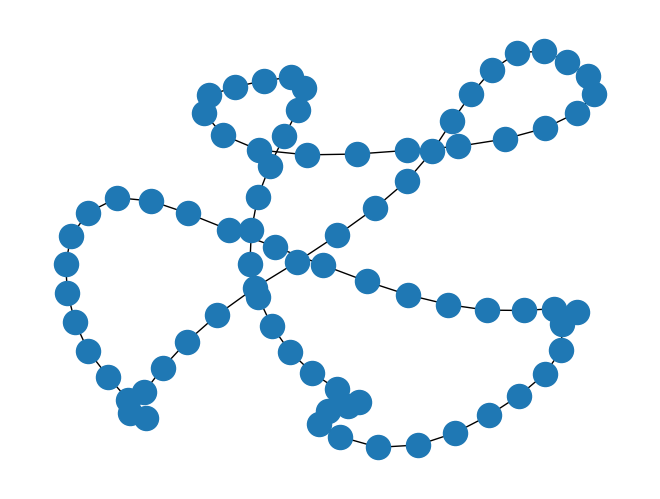

In [32]:
ring = nx.grid_graph(dim=[80], periodic=True)
nx.draw(ring)

In [49]:
n = 80
psi_0 = np.zeros(n)
#psi_0[n//2] = 1
psi_0[0] = 1

anderson_ring = AndersonGraph(graph=ring, psi_0=psi_0, eps_range=[-1, 1], t_hop=1)

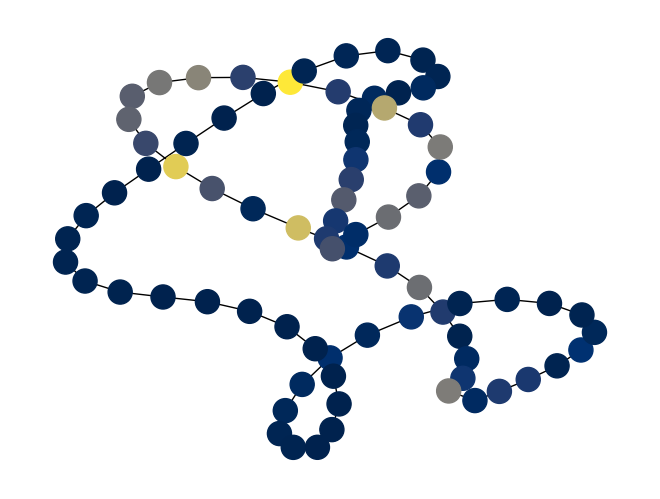

In [50]:
anderson_ring.plot_density(17)

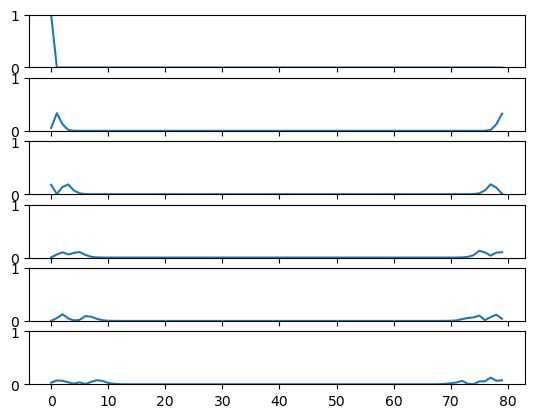

In [51]:
fig, axs = plt.subplots(6)
for i, ax in enumerate(axs):
    psi_t = anderson_ring.psi_at_t(i)
    density = np.real(np.multiply(psi_t.conj(), psi_t))
    ax.plot(density)
    ax.set_ylim(0, 1)
    #sum(density)